In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [3]:
train_df = pd.read_parquet('../data/feature_engineering_v3_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v3_test_df.parquet')

# pd.read_parquet('../data/ReRank2nd_ver1_train_df.parquet')
# pd.read_parquet('../data/ReRank2nd_ver1_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

# Ranking学習の場合、Taregetの数字を変える
# 1を3に変える https://blog.recruit.co.jp/data/articles/lgbm_rank/
#train_df['target'] = train_df['target'].map({1: 3, 0: 0})

print(train_df['target'].value_counts())
# print(test_df['target'].value_counts())

0    2725823
1     161157
Name: target, dtype: int64


<AxesSubplot:>

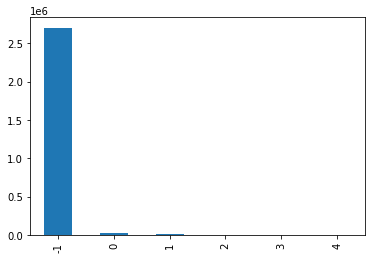

In [24]:
train_df[train_df['target'] == 0]['seq_no'].value_counts().plot(kind='bar')

<AxesSubplot:>

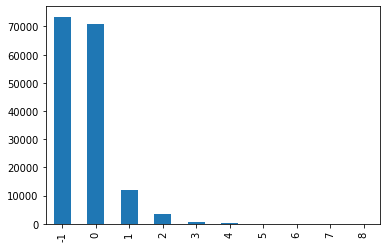

In [23]:

train_df[train_df['target'] == 1]['seq_no'].value_counts().plot(kind='bar')

In [4]:
train_label

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


In [5]:
train_label[train_label["session_id"] == '000104bdffaaad1a1e0a9ebacf585f33']

,session_id,yad_no
4,000104bdffaaad1a1e0a9ebacf585f33,96


In [6]:
train_df.groupby('session_id').size().value_counts()

10    288698
dtype: int64

In [43]:
"""
# 各session_idにおけるtargetの合計を計算
train_df['target_sum'] = train_df.groupby('session_id')['target'].transform('sum')
# 合計が0より大きいsession_idのみを保持することで、すべてのtargetが0のsession_idを削除
train_df = train_df[train_df['target_sum'] > 0]
# target_sum列はもう不要なので削除
train_df.drop('target_sum', axis=1, inplace=True)
"""

In [45]:
"""
train_df.reset_index(drop=True, inplace=True)
train_df
"""

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no
0,000104bdffaaad1a1e0a9ebacf585f33,96,1,0,1,1,1,0,0,0,228.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,5,17,27,31,1725156,136135,52732,51851,1379,0,0.016339,0.025044,0.026324,0.025747,0.025022
1,000104bdffaaad1a1e0a9ebacf585f33,902,0,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,5,17,27,31,1725156,136135,52732,51851,1336,0,0.016339,0.025044,0.026324,0.025747,0.039778
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0,-1,0,1,-1,-1,0,0,144.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,179.0,547.5,58.0,5.0,2.0,2.0,5,17,27,31,1725156,136135,52732,51851,1339,0,0.016339,0.025044,0.026324,0.025747,0.047794
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,5,17,27,31,1725156,136135,52732,51851,1349,0,0.016339,0.025044,0.026324,0.025747,0.040073
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0,-1,0,1,-1,-1,0,0,176.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,141.0,979.5,128.0,14.0,10.0,10.0,5,17,27,31,1725156,136135,52732,51851,1348,0,0.016339,0.025044,0.026324,0.025747,0.040073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11709595,fffe8c99c5b332190c3d4a2d6e7c5073,9368,0,-1,0,1,-1,-1,0,0,24.0,1.0,0,1.0,-1.0,-1.0,-1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,21.0,7477.5,286.0,38.0,32.0,25.0,9,22,35,39,328406,37724,36204,31431,801,4,0.024851,0.030654,0.028250,0.027672,0.012422
11709596,fffe8c99c5b332190c3d4a2d6e7c5073,3046,0,-1,0,1,-1,-1,0,0,22.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,17.0,8132.5,315.0,44.0,36.0,26.0,9,22,35,39,328406,37724,36204,31431,785,4,0.024851,0.030654,0.028250,0.027672,0.007974
11709597,fffe8c99c5b332190c3d4a2d6e7c5073,4732,0,-1,0,1,-1,-1,0,0,33.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,17.0,8132.5,315.0,44.0,36.0,26.0,9,22,35,39,328406,37724,36204,31431,736,4,0.024851,0.030654,0.028250,0.027672,0.018739
11709598,fffe8c99c5b332190c3d4a2d6e7c5073,6214,0,-1,0,1,-1,-1,0,0,35.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,16.0,8318.5,322.0,47.0,38.0,28.0,9,22,35,39,328406,37724,36204,31431,712,4,0.024851,0.030654,0.028250,0.027672,0.000000


### LightGBM Ranker

In [7]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
# Target Encodingを除いてみる

all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd')]


target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# LightGBM のパラメータ
params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': [1, 3],
    'label_gain':"0,1,5", # ここを指定すると、ターゲットの重み付けができる　https://blog.recruit.co.jp/data/articles/lgbm_rank/
    'boosting_type': 'gbdt',
    'learning_rate': 0.001,
    'n_estimators' : 1000,
    'num_leaves': 31,
    #'max_depth': -1,
    'seed': 42531,
}

map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # クエリごとのデータポイント数を計算
    train_groups = train_data.groupby(query_ids).size().values
    val_groups = valid_data.groupby(query_ids).size().values

    # LightGBMデータセットを作成
    lgb_train = lgb.Dataset(train_data[features], label=train_data[target], group=train_groups)
    lgb_val = lgb.Dataset(valid_data[features], label=valid_data[target], group=val_groups)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=50, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(valid_data[features])
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2309580
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4154
[LightGBM] [Info] Number of data points in the train set: 2309580, number of used features: 35
[LightGBM] [Info] Total groups: 57740, total data: 577400
[1]	valid_0's map@1: 0.759456	valid_0's map@3: 0.7916
Training until validation scores don't improve for 50 rounds
[2]	valid_0's map@1: 0.758365	valid_0's map@3: 0.789484
[3]	valid_0's map@1: 0.759179	valid_0's map@3: 0.790783
[4]	valid_0's map@1: 0.757915	valid_0's map@3: 0.789975
[5]	valid_0's map@1: 0.758556	valid_0's map@3: 0.789747
[6]	valid_0's map@1: 0.758902	valid_0's map@3: 0.790085
[7]	valid_0's map@1: 0.758971	valid_0's map@3: 0.790498
[8]	valid_0's map@1: 0.759196	valid_0's map@3: 0.790648
[9]	valid_0's map

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2309580
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4153
[LightGBM] [Info] Number of data points in the train set: 2309580, number of used features: 35
[LightGBM] [Info] Total groups: 57740, total data: 577400
[1]	valid_0's map@1: 0.761431	valid_0's map@3: 0.792963
Training until validation scores don't improve for 50 rounds
[2]	valid_0's map@1: 0.760132	valid_0's map@3: 0.791317
[3]	valid_0's map@1: 0.761188	valid_0's map@3: 0.792593
[4]	valid_0's map@1: 0.759318	valid_0's map@3: 0.790726
[5]	valid_0's map@1: 0.760998	valid_0's map@3: 0.792602
[6]	valid_0's map@1: 0.760599	valid_0's map@3: 0.791574
[7]	valid_0's map@1: 0.75982	valid_0's map@3: 0.791883
[8]	valid_0's map@1: 0.75956	valid_0's map@3: 0.791837
[9]	valid_0's map

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2309580
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4144
[LightGBM] [Info] Number of data points in the train set: 2309580, number of used features: 35
[LightGBM] [Info] Total groups: 57740, total data: 577400
[1]	valid_0's map@1: 0.761153	valid_0's map@3: 0.792841
Training until validation scores don't improve for 50 rounds
[2]	valid_0's map@1: 0.762885	valid_0's map@3: 0.794547
[3]	valid_0's map@1: 0.762158	valid_0's map@3: 0.793748
[4]	valid_0's map@1: 0.761967	valid_0's map@3: 0.794201
[5]	valid_0's map@1: 0.7624	valid_0's map@3: 0.794224
[6]	valid_0's map@1: 0.762366	valid_0's map@3: 0.793953
[7]	valid_0's map@1: 0.761257	valid_0's map@3: 0.793921
[8]	valid_0's map@1: 0.761171	valid_0's map@3: 0.792968
[9]	valid_0's map

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2309590
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4155
[LightGBM] [Info] Number of data points in the train set: 2309590, number of used features: 35
[LightGBM] [Info] Total groups: 57739, total data: 577390
[1]	valid_0's map@1: 0.761773	valid_0's map@3: 0.793256
Training until validation scores don't improve for 50 rounds
[2]	valid_0's map@1: 0.763245	valid_0's map@3: 0.794024
[3]	valid_0's map@1: 0.76082	valid_0's map@3: 0.791343
[4]	valid_0's map@1: 0.763176	valid_0's map@3: 0.794275
[5]	valid_0's map@1: 0.76037	valid_0's map@3: 0.791689
[6]	valid_0's map@1: 0.762431	valid_0's map@3: 0.793727
[7]	valid_0's map@1: 0.762137	valid_0's map@3: 0.794171
[8]	valid_0's map@1: 0.761998	valid_0's map@3: 0.793355
[9]	valid_0's map

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2309590
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4156
[LightGBM] [Info] Number of data points in the train set: 2309590, number of used features: 35
[LightGBM] [Info] Total groups: 57739, total data: 577390
[1]	valid_0's map@1: 0.759729	valid_0's map@3: 0.792575
Training until validation scores don't improve for 50 rounds
[2]	valid_0's map@1: 0.759313	valid_0's map@3: 0.791449
[3]	valid_0's map@1: 0.759054	valid_0's map@3: 0.791314
[4]	valid_0's map@1: 0.756127	valid_0's map@3: 0.788214
[5]	valid_0's map@1: 0.759487	valid_0's map@3: 0.792321
[6]	valid_0's map@1: 0.758361	valid_0's map@3: 0.790249
[7]	valid_0's map@1: 0.759262	valid_0's map@3: 0.792217
[8]	valid_0's map@1: 0.757928	valid_0's map@3: 0.790101
[9]	valid_0's map@1: 0.758863	valid_0's map@3: 0.791576
[10]	valid_0's map@1: 0

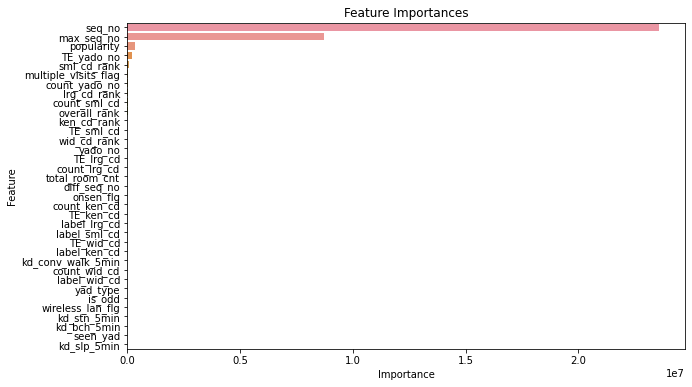

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importance(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [9]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yado_no', 'oof_pred']].head()

,session_id,yado_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,96,0.028563
1,000104bdffaaad1a1e0a9ebacf585f33,3894,-0.017555
2,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.022155
3,000104bdffaaad1a1e0a9ebacf585f33,12491,-0.023706
4,000104bdffaaad1a1e0a9ebacf585f33,10915,-0.025609


In [10]:
# Use 'session_id' from train_label to order train_df
train_df_ordered = train_df.set_index('session_id').loc[train_label['session_id']].reset_index()[['session_id', 'yado_no', 'oof_pred']]
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11101,0.001626
1,000007603d533d30453cc45d0f3d119f,11134,0.001626
2,000007603d533d30453cc45d0f3d119f,7157,0.001076
3,000007603d533d30453cc45d0f3d119f,997,0.001091
4,000007603d533d30453cc45d0f3d119f,5821,0.001459


In [11]:
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11101,0.001626
1,000007603d533d30453cc45d0f3d119f,11134,0.001626
2,000007603d533d30453cc45d0f3d119f,7157,0.001076
3,000007603d533d30453cc45d0f3d119f,997,0.001091
4,000007603d533d30453cc45d0f3d119f,5821,0.001459


In [12]:
# train_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = train_df_ordered.sort_values(by=['session_id', 'oof_pred'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
result_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
result_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
result_df = result_df.reset_index()

result_df.head()

,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,12837,11101,11134,5821,4391,997,7157,1648,12846,8927
1,0000ca043ed437a1472c9d1d154eb49b,2570,8253,13717,825,1092,13682,3564,8677,3184,8140
2,0000d4835cf113316fe447e2f80ba1c8,918,9039,9854,13642,7796,11031,6676,2957,6722,7509
3,0000fcda1ae1b2f431e55a7075d1f500,1341,10483,11715,8355,9438,9790,7812,1924,6178,755
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,12491,10915,11380,902,1908,5490,12338


In [13]:
train_label

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


In [14]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.drop(columns=['session_id']).values

In [15]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 

In [16]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [18]:
# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.37840023303310205


### 予測ファイルの作成

In [24]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.09838724 -0.06833824 -0.06230188 ...  0.00963597  0.0157041
 -0.01178429]
8735000


In [25]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yado_no', 'target']].head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.098387
1,00001149e9c73985425197104712478c,4545,-0.068338
2,00001149e9c73985425197104712478c,9534,-0.062302
3,00001149e9c73985425197104712478c,6563,-0.062302
4,00001149e9c73985425197104712478c,4420,-0.086568


In [26]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [27]:
# Use 'session_id' from test_session to order test_df
test_df_ordered = test_df.set_index('session_id').loc[test_session['session_id']].reset_index()[['session_id', 'yado_no', 'target']]
test_df_ordered.head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.098387
1,00001149e9c73985425197104712478c,4545,-0.068338
2,00001149e9c73985425197104712478c,9534,-0.062302
3,00001149e9c73985425197104712478c,6563,-0.062302
4,00001149e9c73985425197104712478c,4420,-0.086568


In [28]:
test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.098387
21,00001149e9c73985425197104712478c,9830,0.006981
27,00001149e9c73985425197104712478c,6766,-0.018558
10,00001149e9c73985425197104712478c,2680,-0.023596
6,00001149e9c73985425197104712478c,5466,-0.034019
...,...,...,...
8734990,ffffe984aafd6127ce8e43e3ca40c79d,5508,-0.053238
8734958,ffffe984aafd6127ce8e43e3ca40c79d,385,-0.077337
8734967,ffffe984aafd6127ce8e43e3ca40c79d,9190,-0.094580
8734968,ffffe984aafd6127ce8e43e3ca40c79d,9182,-0.094580


In [29]:
# test_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
submit_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
submit_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
submit_df = submit_df.reset_index()

submit_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,9830,6766,2680,5466,2040,11496,9534,6563,10233
1,0000e02747d749a52b7736dfa751e258,11822,2439,143,4066,6555,12862,7913,5267,1266,11237
2,0000f17ae2628237d78d3a38b009d3be,757,410,9910,2267,11001,10485,10104,6721,6730,1774
3,000174a6f7a569b84c5575760d2e9664,12341,3359,6991,5657,2795,277,2047,7049,6489,5080
4,00017e2a527901c9c41b1acef525d016,12029,9623,5372,3844,12524,6703,3187,13590,6576,5106


In [30]:
# 欠損がないかをチェック
print(submit_df.isnull().sum(axis=1).sum())
print(submit_df.shape)

0
(174700, 11)


In [31]:
submit_df.drop(columns=['session_id']).to_csv('../submissions/lgbRanker_ver1.csv', index=False)